# (In)compressible Poiseuille channel fluid flow

#### Incompressible Poiseuille channel fluid flow (old notes)

For this test case, we will closely follow the FENICS tutorial https://fenicsproject.org/pub/tutorial/html/._ftut1009.html in order to validate our method.


The incompressible Navier-Stokes equations are:
$$
\begin{aligned}
\rho\left(\frac{\partial u}{\partial t}+u \cdot \nabla u\right) & =\nabla \cdot \sigma(u, p)+f \\
\nabla \cdot u & =0 .
\end{aligned}
$$

for a Newtonian fluid we have
$$
\sigma(u, p)=2 \mu \epsilon(u)-p I
$$
where $\epsilon(u)$ is the strain-rate tensor
$$
\epsilon(u)=\frac{1}{2}\left(\nabla u+(\nabla u)^T\right)



In standard fluid-kinetics notation:

$$
\Delta p=\frac{8 \mu L Q}{\pi R^4}=\frac{8 \pi \mu L Q}{A^2}
$$

where:
- $\Delta p$ is the pressure difference between the two ends,
- $L$ is the length of pipe,
- $\mu$ is the dynamic viscosity,
- $Q$ is the volumetric flow rate,
- $R$ is the pipe radius,
- $A$ is the cross sectional area of pipe.

### Plane Poiseuille flow
Plane Poiseuille flow is flow created between two infinitely long parallel plates, separated by a distance $h$ with a constant pressure gradient $G=-\frac{\mathrm{d} p}{\mathrm{dx}}$ is applied in the direction of flow. The flow is essentially unidirectional because of infinite length. The Navier-Stokes equations reduce to
$$
\frac{\mathrm{d}^2 u}{\mathrm{~d} y^2}=-\frac{G}{\mu}
$$
with no-slip condition on both walls
$$
u(0)=0, \quad u(h)=0
$$
Therefore, the velocity distribution and the volume flow rate per unit length are
$$
u(y)=\frac{G}{2 \mu} y(h-y), \quad Q=\frac{G h^3}{12 \mu}
$$

![image.png](attachment:image.png)


In [1]:
import numpy as np
import math
import copy
import os
import sys

# Add base directory (~/ddg/ddgclib/) to sys.path from notebook location
#module_path = os.path.abspath(os.path.join('../..'))
#if module_path not in sys.path:
#    sys.path.append(module_path)

from scipy.spatial import Delaunay

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ddg imports (from ddgclib package)
from ddgclib import *
from ddgclib._complex import Complex
from ddgclib._curvatures import *
from ddgclib._capillary_rise_flow import *
from ddgclib._capillary_rise import *
from ddgclib._eos import *
from ddgclib._misc import *
from ddgclib._plotting import *

# barycentric imports (from ddgclib.barycentric subpackage)
from ddgclib.barycentric._duals import compute_vd, triang_dual, plot_dual_mesh_2D, _set_boundary
from ddgclib._plotting import plot_dual

# compute duals (and Delaunay dual from a set of points)
from ddgclib.barycentric._duals import compute_vd, _merge_local_duals_vector, triang_dual, plot_dual


# Plots
from ddgclib.barycentric._duals import  plot_dual_mesh_2D, plot_dual_mesh_3D

# Geometry and dual computations
from ddgclib.barycentric._duals import area_of_polygon, e_star, volume_of_geometric_object, plot_dual, v_star

# Boundary geometry
from ddgclib.barycentric._duals import  _set_boundary, _find_plane_equation, _find_intersection, _reflect_vertex_over_edge

# Area computations
from ddgclib.barycentric._duals import d_area

# Volume computations (including helper functions)
from ddgclib.barycentric._duals import _signed_volume_parallelepiped, _volume_parallelepiped
# DDG gradient operations on primary edges (for continuum)
from ddgclib.barycentric._duals import dP, du, dudt

ModuleNotFoundError: No module named 'ddgclib._complex'

In [11]:
def u_x_analytical(y):
    """
    General pipe solution (NOT planar case)
    """
    return 4 * y * (1 - y)

def u_plane_analytical(x):
    y = x[1]
    return (G / 2 * mu) * y * (h - y)

def v_error(HC):
    MSE = 0
    for v in HC.V:
        u_anal = u_plane_analytical(v.x_a)
        MSE += (v.u[1]- u_anal)**2
    return MSE/HC.V.size()


In [12]:
# Condtions

In [13]:
import numpy as np
L = 1  # m
Q = 1  # m3 / s
R = 1  # m
A = 1  # m2  # = 2 pi * R**2 # for pipe
# Domain:
x_lb = 0
x_ub = R
y_lb = 0
y_ub = R


#u_in = 1  # m⋅s−2, initial and inlet velocity
u_in = 0.001  # m⋅s−2, initial and inlet velocity
P_in = 101325 # Pa (kg⋅m−1⋅s−2), atmospheric pressure
u_in = 0.001  # m⋅s−2, initial and inlet velocity

# Physical parameters
mu = 8.90 * 1e-4  # Pa·s
h = R  # m, plate seperation
Q = u_in * A  # m3/s, volumetric flowrate (CHECK)
G = (Q * 12 * mu) / (h**3)  # pressure gradient(?)
rho = 1000  # kg / m3
#G = dP/ L
Re = rho * Q * L / mu
Re

# Pressure drop for pipe
dP_anal = (8 * np.pi * mu * L * Q) / (A**2)


In [14]:
# Incompressible Poiseuile case
from cases.Poiseuile.Poiseuile import incom_Poi

In [17]:
## Initial conditions
# velocity
def v_IC(HC):
    # Assign velocity field to all points:
    for v in HC.V:
        v.u = np.array([u_ic(v.x_a), 0])

# velocity
def v_IC(HC, u_in):
    # Assign velocity field to all points:
    for v in HC.V:
        v.u = np.array([u_in, 0])

# mass
def mass_IC(HC):
    # Set mass of each fluid particle:
    for v in HC.V:
        # Compute the dual area around a particle:
        area = d_area(v)
        V = area * 1  # m3, can be modified later
        # Set mass in kg
        v.m = rho * V

# Pressure IC (new)
def P_IC(HC):
    # Assign velocity field to all points:
    for v in HC.V:
        # NOTE: We assume that the vector here is in fact the
        #       pressure _gradient_ potential, which is not
        #       equivalent to the scalar pressure field.
        P_i = P_ic(v.x_a[0])
        v.P = np.array([P_i, P_i])  # Diagonal components # Pressure IC (new)

def P_ic(x):
    """
    Initial pressure condition (ASSUMED linear based on pressure drop)
    """
    return P_in - ((8 * np.pi * mu * x * Q) / (A**2))  # P_in - dP


# 2D

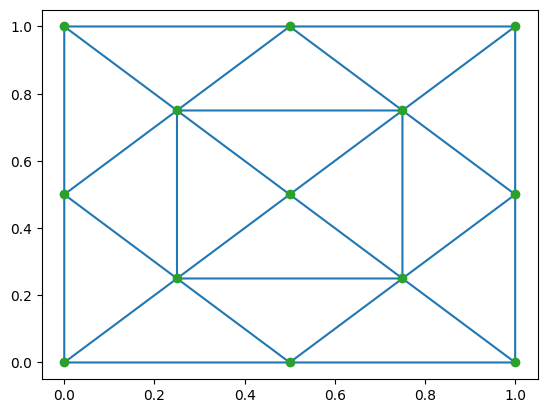

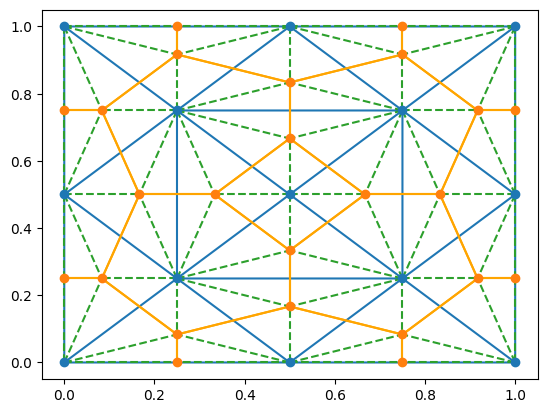

In [19]:
#NOTE: This was moved after defining the code below to validate the 2D:
domain = [(0, 1),]*2

points = incom_Poi(domain, refinements=1)
HC, tri = triang_dual(points, plot_delaunay=True)
#HC.dim = 2
# NEW: Compute boundaries
bV = set()
for v in HC.V:
    if ((v.x_a[0] == 0.0 or v.x_a[1] == 0.0) or
        (v.x_a[0] == 1.0 or v.x_a[1] == 1.0)):
        bV.add(v)
        
for bv in bV:
    _set_boundary(bv)
    
# Now compute duals as normal   
compute_vd(HC, cdist =1e-10)

plot_dual_mesh_2D(HC, tri, points)

In [25]:
import numpy as np

# Assuming Vertex class is defined in your library as follows:
# class Vertex:
#     def __init__(self, x):
#         self.x = x  # tuple
#         self.x_a = np.array(x, dtype='float64')
#         self.nn = set()
#         self.u = None
#         self.P = None
#         self.m = None
# If not, adjust accordingly based on your implementation.

def extend_domain(HC, direction='right'):
    """
    Extend the simplicial complex HC by adding a shifted copy of the mesh
    to the left or right, merging overlapping boundary vertices and preserving connectivity.

    :param HC: The Complex instance to extend.
    :param direction: 'left' or 'right' to specify the extension direction.
    """
    if direction not in ['left', 'right']:
        raise ValueError("Direction must be 'left' or 'right'.")

    # Assuming HC.V is a dict {tuple: Vertex}
    # Compute current bounds (assuming 2D, x is dimension 0)
    if not HC.V:
        raise ValueError("HC has no vertices.")

    positions = [v.x for v in HC.V]
    xs = [p[0] for p in positions]
    min_x = min(xs)
    max_x = max(xs)
    dx = max_x - min_x

    shift = dx if direction == 'right' else -dx
    shift_vec = np.array([shift, 0.0])  # Assuming 2D

    # Step 1: Create mapping from original vertices to their shifted counterparts
    # Get or create new vertices for shifted positions
    #old_vertices = list(HC.V.values())
    old_vertices = list(HC.V)
    mapping = {}

    for v in old_vertices:
        new_x_a = v.x_a + shift_vec
        new_x = tuple(new_x_a)

        if new_x in HC.V:
            new_v = HC.V[new_x]
        else:
            #new_v = Vertex(new_x)  # Create new Vertex
            new_v = HC.V[(new_x)]

        mapping[v] = new_v

    # Step 2: Replicate connectivity for the new/shifted mesh
    for v in old_vertices:
        new_v = mapping[v]
        for old_nn in v.nn:
            new_nn = mapping[old_nn]
            new_v.nn.add(new_nn)
            new_nn.nn.add(new_v)  # Ensure undirected

    # Note: After extension, you may need to re-run IC functions like v_IC, mass_IC, P_IC
    # to set properties on new vertices.

In [26]:
extend_domain(HC, direction='right')

In [28]:
for v in HC.V:
    points.append(v.x_a)
points = np.array(points, dtype='float64')

plot_dual_mesh_2D(HC, tri, points)

AttributeError: 'numpy.ndarray' object has no attribute 'append'